In [11]:
import pickle
import glob
import json
import os

os.chdir('/home/walml/repos/morphology-tools/anomaly')
import shared

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic

import umap

In [2]:
# embed_loc = '/home/walml/repos/morphology-tools/anomaly/data/latest_embed.pickle'
# with open(embed_loc, 'rb') as f:
#     embed = pickle.load(f)
# scl = StandardScaler()
# embed = scl.fit_transform(embed)

In [4]:
features, labels, responses, metadata = shared.load_gz2_data(method='cnn', anomalies='odd', max_galaxies=60715)

239695 239695 239695


In [5]:
embed = shared.get_embed(features, n_components=20)
scl = StandardScaler()
embed = scl.fit_transform(embed)

(-4, 2)

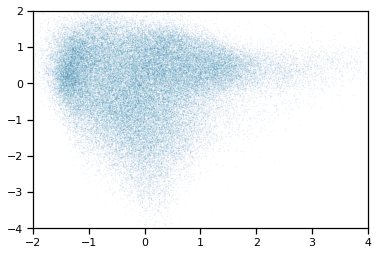

In [6]:
plt.scatter(embed[:, 0], embed[:, 1], alpha=.1, s=.1)
plt.xlim(-2, 4)
plt.ylim(-4, 2)

In [53]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import loguniform

In [9]:
embed_train, embed_test, labels_train, labels_test, responses_train, responses_test = train_test_split(embed, labels, responses, random_state=0)

In [114]:
n_training = 200

In [108]:

kernel = RationalQuadratic() + WhiteKernel()  # default params
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)

In [109]:
gp.get_params().keys()

dict_keys(['alpha', 'copy_X_train', 'kernel__k1', 'kernel__k2', 'kernel__k1__length_scale', 'kernel__k1__alpha', 'kernel__k1__length_scale_bounds', 'kernel__k1__alpha_bounds', 'kernel__k2__noise_level', 'kernel__k2__noise_level_bounds', 'kernel', 'n_restarts_optimizer', 'normalize_y', 'optimizer', 'random_state'])

In [110]:
gp.score(embed_train, responses_train), gp.score(embed_test, responses_test) # R2 coefficient of determination

(-0.6427869612072141, -0.6479225466880514)

In [115]:
gp.fit(embed_train[:n_training], responses_train[:n_training])
gp.score(embed_train, responses_train), gp.score(embed_test, responses_test) # R2 coefficient of determination

(0.5657194620881215, 0.56871456043447)

In [128]:

kernel2 = RationalQuadratic(alpha=2., length_scale=2.) + WhiteKernel()  # default params
gp2 = GaussianProcessRegressor(kernel=kernel2, random_state=0)
gp2.fit(embed_train[:n_training], responses_train[:n_training])
gp2.score(embed_train, responses_train), gp.score(embed_test, responses_test) # R2 coefficient of determination

(0.5657193341617843, 0.56871456043447)

In [ ]:
# this whole thing is silly - gp optimises it's own kernel hp's...abandon

In [116]:
import scipy

In [117]:
# Set the parameters by cross-validation
tuned_parameters = [{
    'kernel': [RationalQuadratic() + WhiteKernel()],
#     'kernel__k1__length_scale': loguniform(1e-5, 1e2),
#     'kernel__k1__alpha': loguniform(1e-5, 1e2),
#     'kernel__k2__noise_level': loguniform(1, 1e4)
    
    'kernel__k1__length_scale': scipy.stats.uniform(0.5, 1.5),
    'kernel__k1__alpha': scipy.stats.uniform(0.5, 1.5),
    'kernel__k2__noise_level': scipy.stats.uniform(0.5, 1.5)
}]


In [118]:
from sklearn.model_selection import RandomizedSearchCV

In [119]:
clf = RandomizedSearchCV(
    GaussianProcessRegressor(),
    tuned_parameters,
#     scoring='explained_variance',
    scoring='r2',
    n_iter=100
)
clf.fit(embed_train[:n_training], responses_train[:n_training])



RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GaussianProcessRegressor(alpha=1e-10,
                                                      copy_X_train=True,
                                                      kernel=None,
                                                      n_restarts_optimizer=0,
                                                      normalize_y=False,
                                                      optimizer='fmin_l_bfgs_b',
                                                      random_state=None),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions=[{'kernel': [RationalQuadratic(alpha=1.65, length_scale=1.79) + WhiteKernel(noise_level=...
                                         'kernel__k1__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7691bfd410>,
                                         'kernel__k1__length_scale': <scipy.stats._distn_infrastructure.rv_frozen o

In [120]:
print(clf.best_params_)

{'kernel': RationalQuadratic(alpha=1.65, length_scale=1.79) + WhiteKernel(noise_level=0.977), 'kernel__k1__alpha': 1.6474073905603754, 'kernel__k1__length_scale': 1.793153323446448, 'kernel__k2__noise_level': 0.9768037938669071}


In [126]:
clf.cv_results_

{'mean_fit_time': array([0.15417719, 0.20142627, 0.19868526, 0.20347281, 0.17649589,
        0.22671967, 0.19630661, 0.22209139, 0.20942574, 0.27123413,
        0.20662565, 0.1958744 , 0.20722165, 0.22015524, 0.22219305,
        0.19989095, 0.27937336, 0.24352708, 0.26977997, 0.35353346,
        0.27654901, 0.25734544, 0.24351783, 0.25861454, 0.26961789,
        0.26078157, 0.26533904, 0.26313496, 0.28155165, 0.28691382,
        0.31923013, 0.28973541, 0.24677863, 0.32579417, 0.2553226 ,
        0.28613243, 0.28174386, 0.24338551, 0.26181569, 0.22773027,
        0.25860238, 0.22651   , 0.22240767, 0.24144707, 0.24881215,
        0.22826681, 0.26402574, 0.26507816, 0.19182529, 0.21601515,
        0.22707896, 0.19138503, 0.20769429, 0.21766152, 0.227143  ,
        0.25613976, 0.26575079, 0.21807203, 0.23607998, 0.19520774,
        0.23557043, 0.22054477, 0.20351443, 0.22256141, 0.24469953,
        0.19680009, 0.23615518, 0.21591215, 0.22217259, 0.20065684,
        0.22868805, 0.24361091,

In [122]:
clf.score(embed_train, responses_train), clf.score(embed_test, responses_test) # reports whatever you set for "scoring" on clf

(0.5657195038718423, 0.5687145902372739)

In [123]:

kernel_best = clf.best_params_['kernel']
gp_best = GaussianProcessRegressor(kernel=kernel_best, random_state=0)

In [125]:
gp_best.fit(embed_train[:n_training], responses_train[:n_training])
gp_best.score(embed_train, responses_train), gp_best.score(embed_test, responses_test) # reports whatever you set for "scoring" on clf

(0.5657195038718423, 0.5687145902372739)

In [ ]:

# pipeline class is used as estimator to enable
# search over different model types


kernel = RationalQuadratic() + WhiteKernel()  # or matern
gp = GaussianProcessRegressor(kernel=kernel, random_state=iteration_n)

pipe = Pipeline([
    ('model', GaussianProcessRegressor())
])


gp_search = {
    'model': [GaussianProcessRegressor(random_state=0)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(svc_search, 40), (linsvc_search, 16)],
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))